## 步骤
1. 提取细胞核掩膜
2. 从 expression_matrix 中提取细胞核的基因表达
3. 将数据做成 anndata 格式
4. 用 ad 和 sc 对应的 api 来做 PCA 和 UMAP

## 需要的数据
1. 1200*1200 的 expression_matrix
2. 全图上的细胞核分割结果

### 注意事项
1. expression_matrix 的大小由 pre 主函数里的 start, end xy 来确定
2. align 文件中有控制二维矩阵大小的部分，需要尽快函数化后由主函数传入

In [1]:
import pandas as pd
import numpy as np

# read tsv file
nuclei = pd.read_csv(
    "/mnt/md0/lei/projects/CellSegmentsation/CellSegmentation/results/task2_result.txt",
    sep=" ",
    header=None,
)
expression_matrix = np.load("dataset/expression_matrix.npy", allow_pickle=True)

In [2]:
results = []
for nuclei_id in nuclei[3].unique():

    if nuclei_id == 0:  # 跳过 NucleiID 为 0 的行
        continue
    # 获取当前细胞核的所有点坐标
    coordinates = nuclei[nuclei[3] == nuclei_id][[0, 1]].values
    expression_data_sum = np.zeros(2000)

    # 遍历每个点，累加基因表达数据
    for coordinate in coordinates:
        x, y = coordinate.astype(int)
        expression_data_sum += expression_matrix[x, y]

    # 将细胞核编号和累加后的基因表达数据加到结果中
    results.append(expression_data_sum.tolist())

# 将结果转换为 numpy 数组
results_array = np.array(results)
results_array.shape

(1117, 2000)

In [3]:
import anndata as ad
import scanpy as sc

# adata = ad.AnnData(results_array)
adata=ad.read_h5ad("dataset/full_gene.h5ad")
adata

AnnData object with n_obs × n_vars = 1440000 × 17943

In [4]:

patchsizey=1200
nuclei_count = len(nuclei[3].unique()) - 1  
gene_count=adata.shape[1]
nuclei_expression = np.zeros((nuclei_count, gene_count))
nuclei_count

1117

In [5]:
import math
def co2idx(x,y,pathcsizey):
    idx = int(math.floor(int(x)) * math.ceil(patchsizey) + math.floor(int(y)))
    return idx

In [6]:
cnt=0
for nuclei_id in nuclei[3].unique():
    if nuclei_id == 0:  # 跳过 NucleiID 为 0 的行
        continue

    # 获取当前细胞核的所有点坐标
    coordinates = nuclei[nuclei[3] == nuclei_id][[0, 1]].values
    expression_data_sum = np.zeros(gene_count)
    
    # 遍历每个点，累加基因表达数据
    for coordinate in coordinates:
        x, y = coordinate.astype(int)
        idx = co2idx(x, y, patchsizey)
        expression_data_sum += adata[idx].X  # 假设 adata 的 .X 存储基因表达数据
    
    # 将累加的数据保存到对应的细胞核行
    nuclei_expression[cnt] = expression_data_sum  # 根据实际情况调整索引
    cnt+=1
# 创建一个新的 AnnData 对象
new_adata = ad.AnnData(nuclei_expression)

In [7]:
adata=new_adata
import json
with open('id2gene.json', 'r') as f:
    id2gene = json.load(f)
adata.var_names = [id2gene.get(var_name, var_name) for var_name in adata.var_names]

In [8]:
adata_ref=sc.read_h5ad("../E16.5_E1S3_cell_bin_whole_brain.h5ad")
common_vars = adata.var_names.intersection(adata_ref.var_names)
adata = adata[:, common_vars].copy()
adata_ref = adata_ref[:, common_vars].copy()
adata = adata[:, adata_ref.var_names].copy()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)

/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_ref, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)

/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [11]:
sc.tl.pca(adata, svd_solver="arpack")
sc.tl.pca(adata_ref, svd_solver="arpack")


In [12]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

2024-03-09 01:58:30.626951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.1/lib64:/usr/local/cuda-12.1/lib64:
2024-03-09 01:58:30.626975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
adata_ref

AnnData object with n_obs × n_vars = 65303 × 17707
    obs: 'Slice', 'region', 'sim anno', 'n_genes_by_counts', 'total_counts', 'annotation'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sim anno_colors', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [14]:
# 假设 adata 是你的新数据集
# 假设 adata_ref 是你的参考数据集，已经包含了标签和降维结果

# 首先，对新数据集进行必要的预处理和PCA
sc.pp.neighbors(adata_ref, n_neighbors=10, n_pcs=40)  # 如果参考数据集还没有计算邻居信息
sc.tl.umap(adata_ref)  # 如果参考数据集还没有UMAP结果
sc.pp.neighbors(adata, use_rep='X_pca')  # 对新数据集计算邻居信息，确保已经进行了PCA

# 使用 ingest 将标签从参考数据集转移到新数据集
sc.tl.ingest(adata, adata_ref, obs='annotation')  # 替换 '类别标签' 为参考数据集中用于分类的列名

# 现在，adata 中就包含了从 adata_ref 转移过来的标签和UMAP坐标
# 可以进行可视化来查看结果


/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/tools/_ingest.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [cat_array[inds].mode()[0] for inds in self._indices]


/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


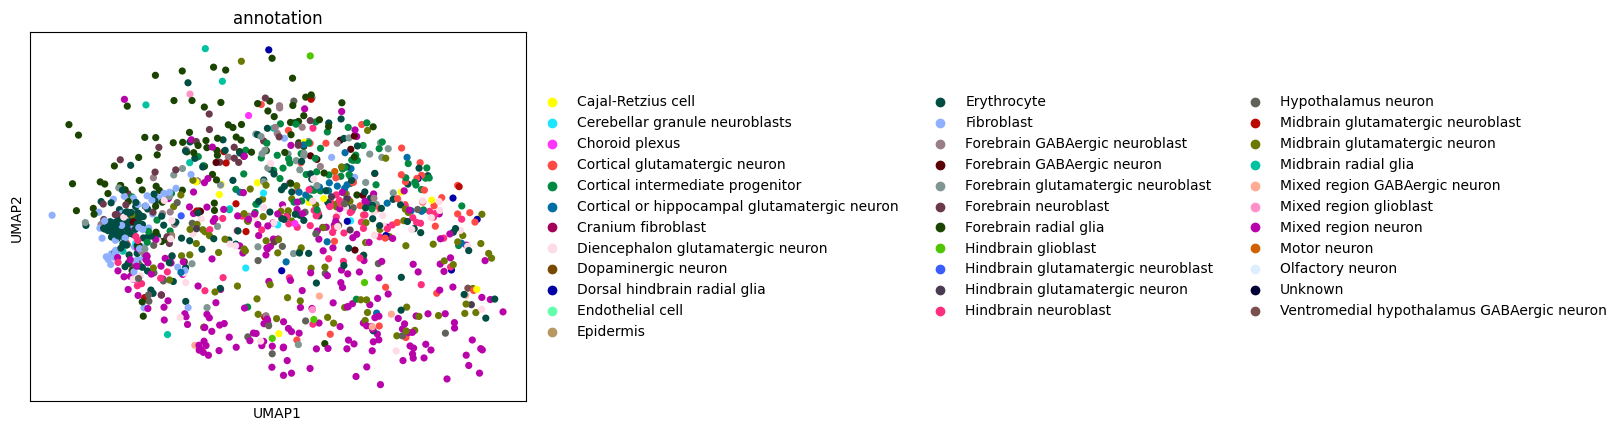

In [15]:
sc.pl.umap(adata, color=['annotation'])